# JDOT with MC simulation

In [1]:
#import sys
#sys.path.insert(0, '../')
import torch
import numpy as np
import matplotlib.pyplot as plt
import ROOT
from ROOT import TFile, vector
from model import *
from utility import *
from dataset import *
from predict import *
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from functools import partial
from tqdm import tqdm

Welcome to JupyROOT 6.26/10


## Datasets

In [2]:
source_file = './source.root'
test_file = './source_test.root'
num_train = 1000
num_test = 200
batch_size = 1024

source_dataset = WaveformSliceDataset(source_file, 'sim', 0, num_train, nleft=5, nright=9)
test_dataset = WaveformSliceDataset(test_file, 'sim', 0, num_test, nleft=5, nright=9)
source_dataloader = DataLoader(source_dataset, batch_size=batch_size, shuffle=False, drop_last=True, sampler=balanced_sampler(source_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True, sampler=balanced_sampler(test_dataset))

Creating dataset: 100%|██████████| 1000/1000 [01:52<00:00,  8.90it/s]


[WaveformSliceDataset] : Total # of waveform slices = 1496309
[WaveformSliceDataset] : Dataset has a size of (15,)


Creating dataset: 100%|██████████| 200/200 [00:25<00:00,  7.75it/s]


[WaveformSliceDataset] : Total # of waveform slices = 298830
[WaveformSliceDataset] : Dataset has a size of (15,)
number of balanced (sig, bkg) = (36879, 36879)
number of balanced (sig, bkg) = (7200, 7200)


## Train the Model

In [3]:
model = DnnModel(embedding=True)
dnn_model = ModelTrainer(model)
dnn_model.fit(source_dataloader, test_dataloader, epoch_size=10, lr=1e-2)
dnn_model.evaluate(test_dataloader)
dnn_model.save('./dnn.pth')

Epoch 0:  Train Loss: 0.252, Train Acc: 0.892
          Val   Loss: 0.214, Val   Acc: 0.918
Epoch 1:  Train Loss: 0.203, Train Acc: 0.917
          Val   Loss: 0.199, Val   Acc: 0.921
Epoch 2:  Train Loss: 0.197, Train Acc: 0.921
          Val   Loss: 0.200, Val   Acc: 0.925
Epoch 3:  Train Loss: 0.193, Train Acc: 0.923
          Val   Loss: 0.203, Val   Acc: 0.921
Epoch 4:  Train Loss: 0.188, Train Acc: 0.926
          Val   Loss: 0.200, Val   Acc: 0.925
Epoch 5:  Train Loss: 0.186, Train Acc: 0.927
          Val   Loss: 0.195, Val   Acc: 0.925
Epoch 6:  Train Loss: 0.183, Train Acc: 0.928
          Val   Loss: 0.193, Val   Acc: 0.927
Epoch 7:  Train Loss: 0.181, Train Acc: 0.928
          Val   Loss: 0.196, Val   Acc: 0.925
Epoch 8:  Train Loss: 0.178, Train Acc: 0.929
          Val   Loss: 0.192, Val   Acc: 0.926
Epoch 9:  Train Loss: 0.178, Train Acc: 0.929
          Val   Loss: 0.192, Val   Acc: 0.925
Test acc. = 0.9250139594078064


## Prediction with the Trained Model

Creating dataset: 100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


[WaveformSliceDataset] : Total # of waveform slices = 14928
[WaveformSliceDataset] : Dataset has a size of (15,)


Making predictions: 100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


FPR = 0.01: (0.8437820672988892, 0.8355704697986577)
FPR = 0.001: (0.9887608885765076, 0.6577181208053692)


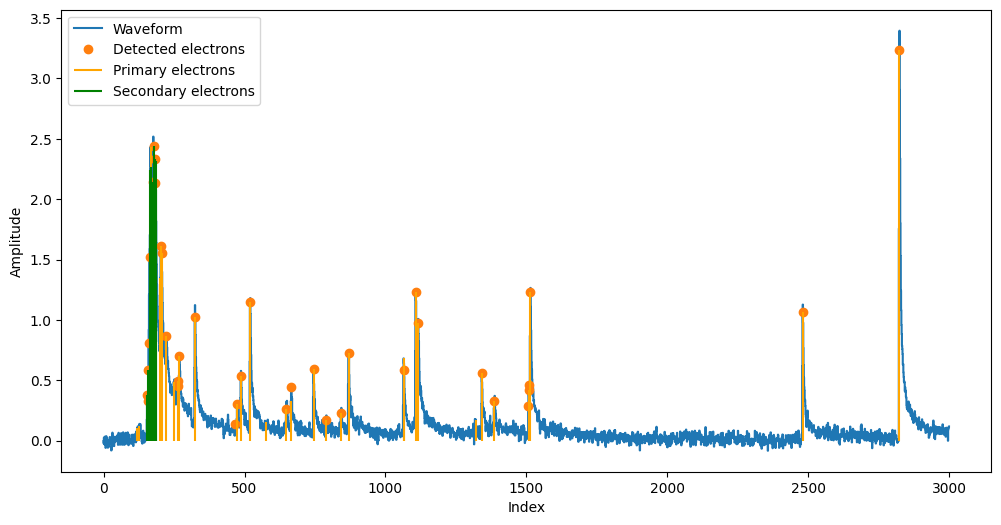

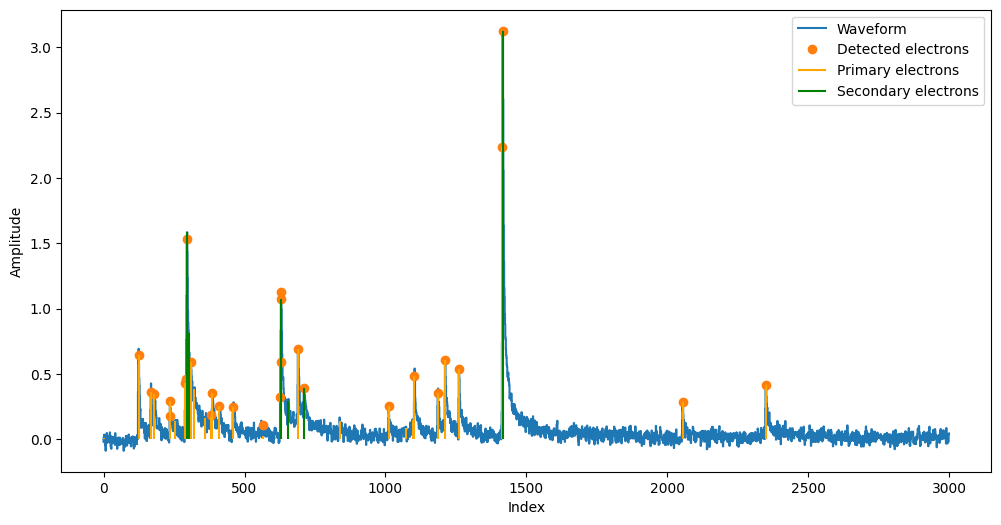

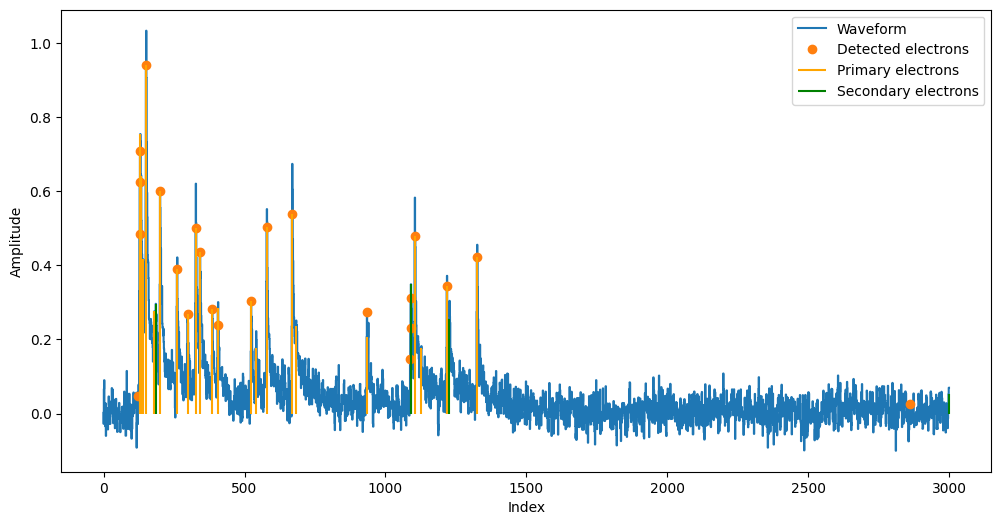

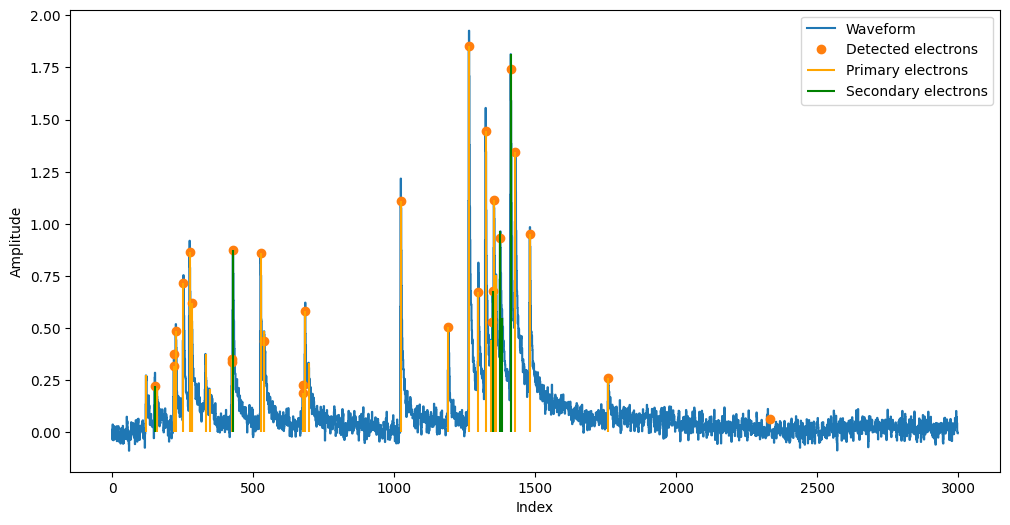

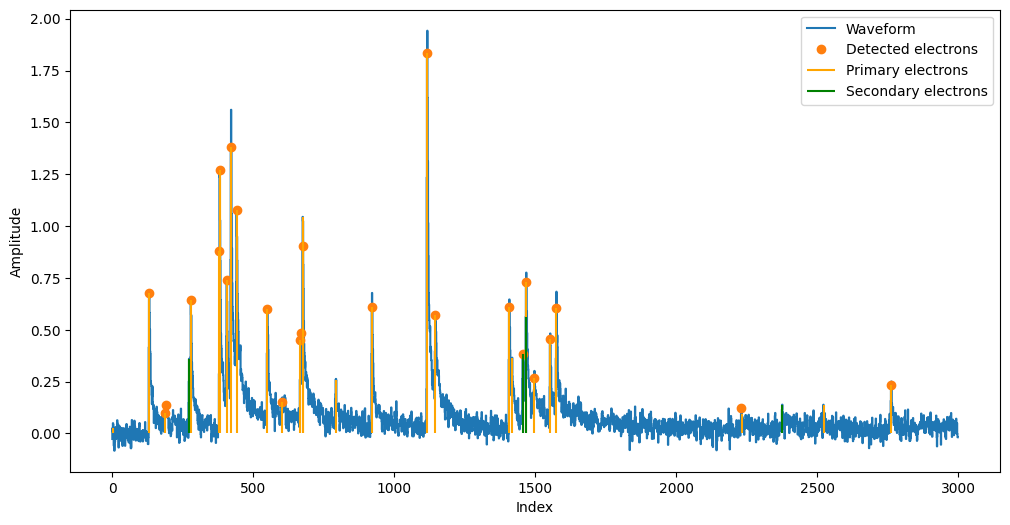

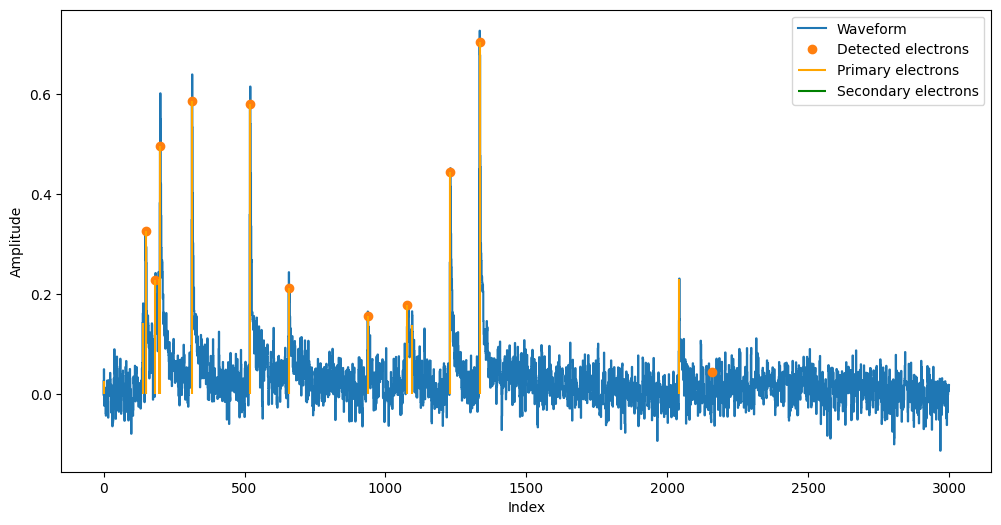

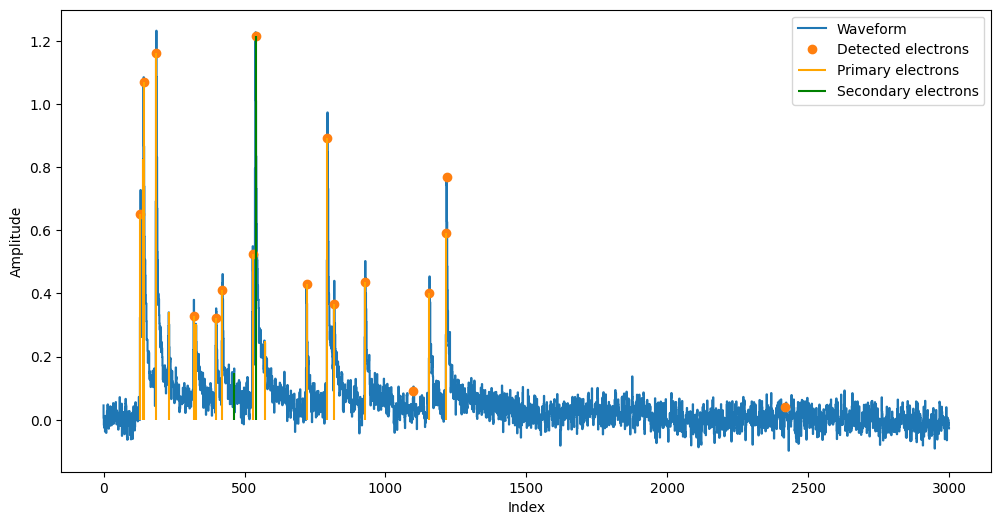

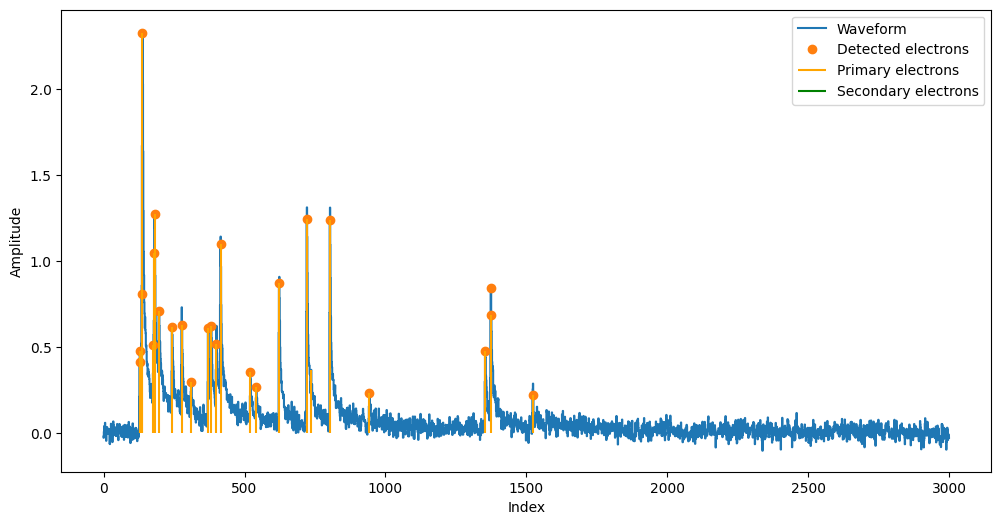

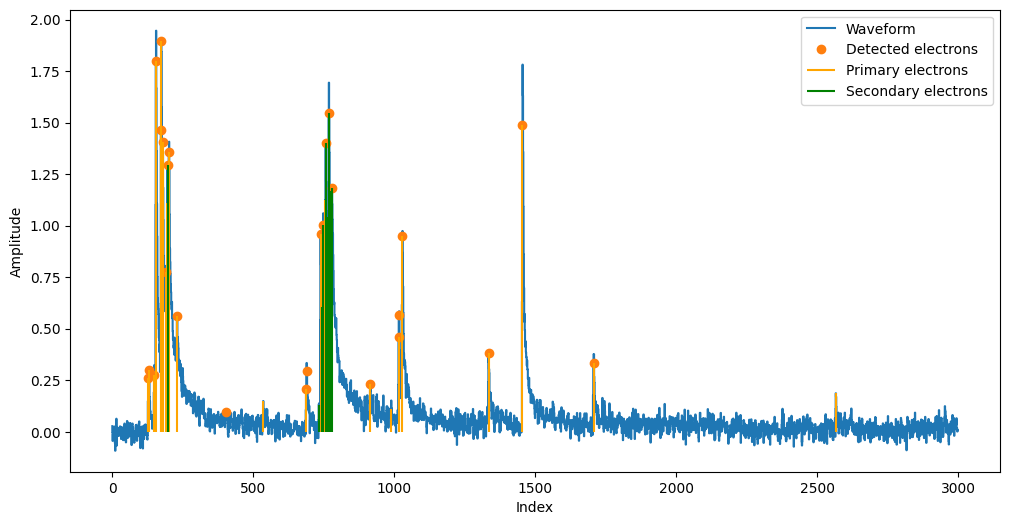

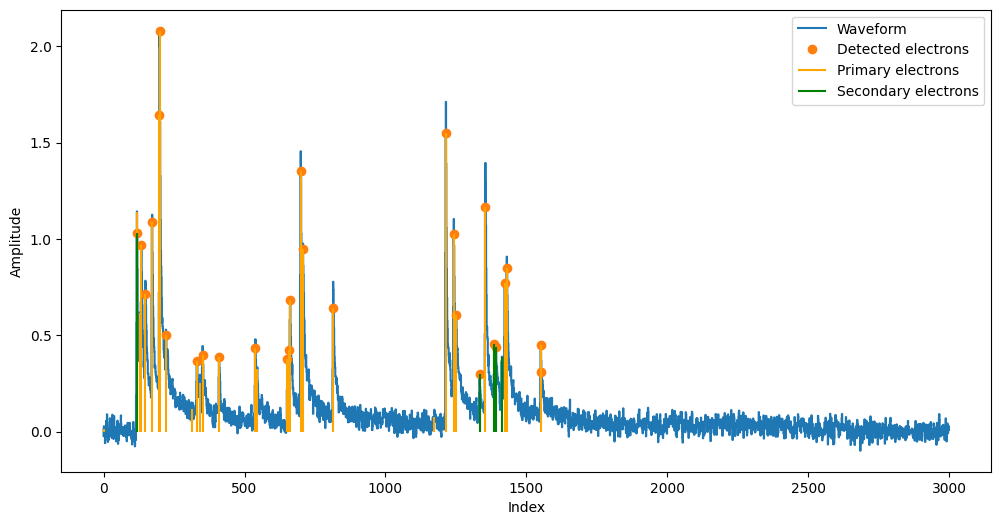

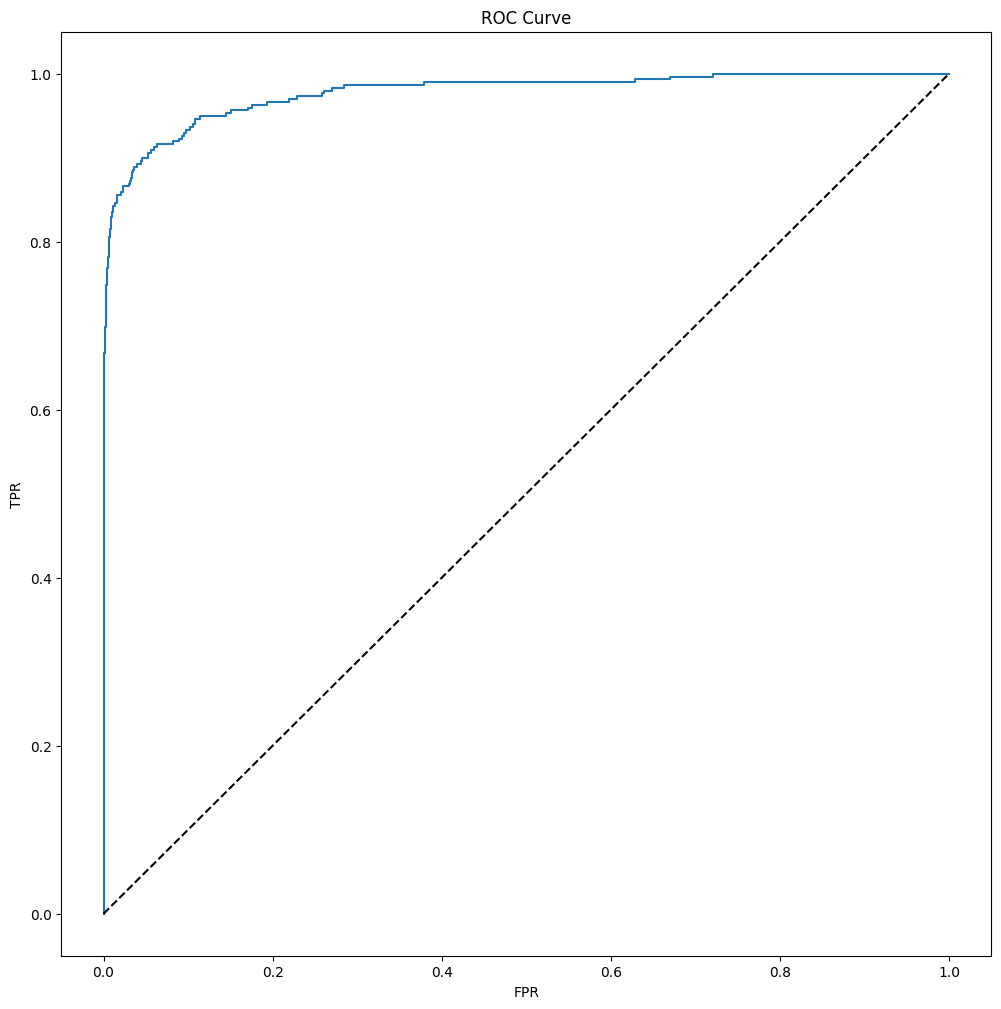

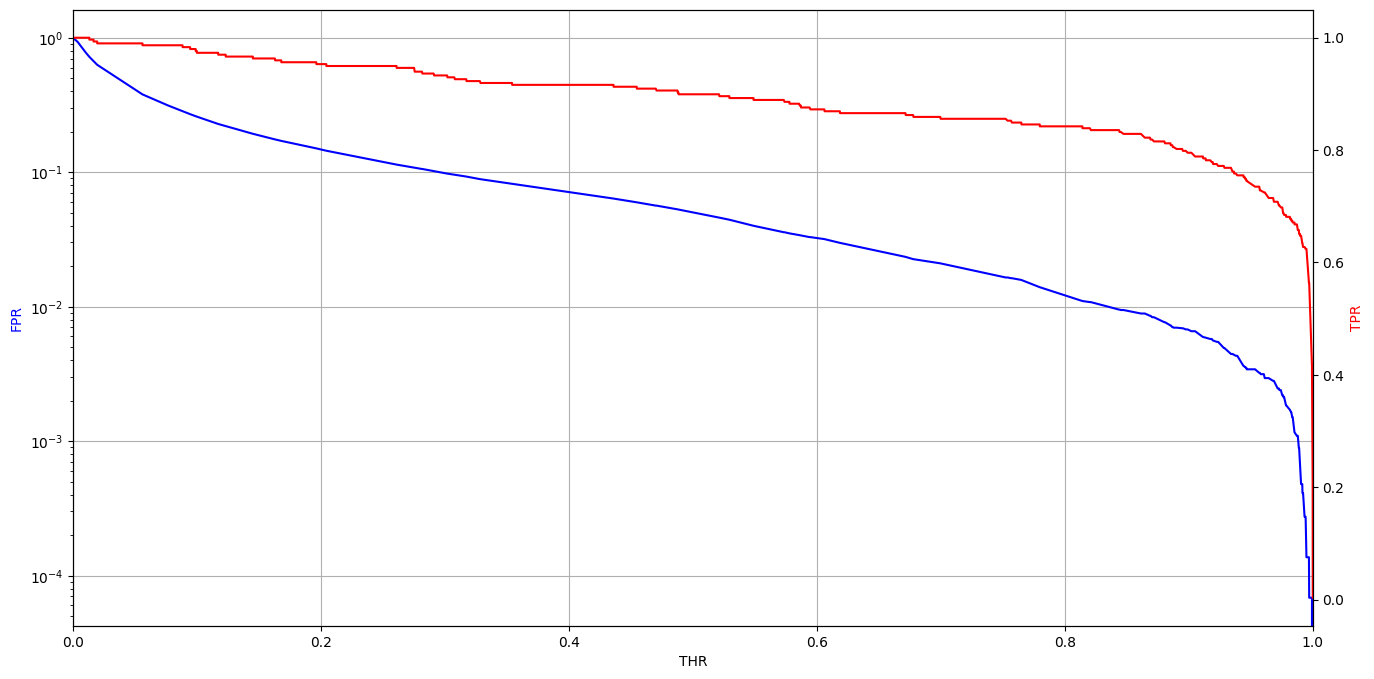

In [4]:
process_waveform(
    infile='source_test.root', 
    intree='sim', 
    outfile='pred.root', 
    mfile='dnn.pth', 
    start=0, 
    length=10, # run 10 events
    sign=1, 
    threshold=0.97, 
    with_tag=True, 
    clustering_cut=-1.
)